In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
#!pip install livelossplot

In [3]:
#import seaborn as sns
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.0.0


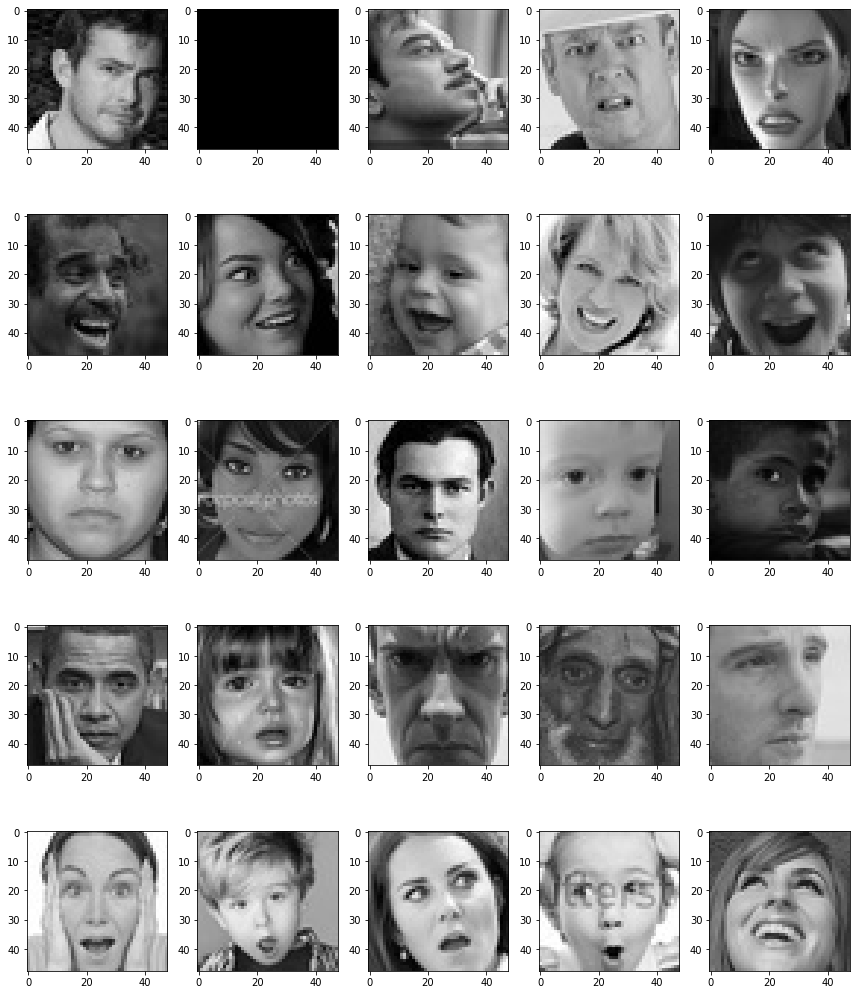

In [4]:
utils.datasets.fer.plot_example_images(plt).show()

In [5]:
num_classes = 0
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/"+expression)))+" "+expression +" images")
    num_classes += 1
print(num_classes)

3995 angry images
7214 happy images
4965 neutral images
4830 sad images
3171 surprise images
5


In [6]:
img_rows, img_cols = 96, 96
# img_size = 48 # old
img_size = 96 
batch_size = 64 # or 32



# datagen_train = ImageDataGenerator(horizontal_flip=True) # old
datagen_train = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=30,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = datagen_train.flow_from_directory("train/",
                                                    # target_size=(img_size,img_size), # old
                                                    target_size=(img_rows,img_cols),
                                                    # color_mode='grayscale', # old
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

# datagen_validation = ImageDataGenerator(horizontal_flip=True) # old
datagen_validation = ImageDataGenerator(rescale=1. / 255,horizontal_flip=True)

validation_generator = datagen_validation.flow_from_directory("test/",
                                                              # target_size=(img_size,img_size), # old
                                                              target_size=(img_rows,img_cols),
                                                              # color_mode='grayscale', # old
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False)

Found 24175 images belonging to 5 classes.
Found 6043 images belonging to 5 classes.


In [ ]:
#IMG_SIZE = 160 # All images will be resized to 160x160

#def format_example(image, label):
#    image = tf.cast(image, tf.float32)
#    image = (image/127.5) - 1
#    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
#    return image, label

In [ ]:
#train = raw_train.map(format_example)
#validation = raw_validation.map(format_example)
#test = raw_test.map(format_example)

In [ ]:
#BATCH_SIZE = 32
#SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
#train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
#validation_batches = validation.batch(BATCH_SIZE)
#test_batches = test.batch(BATCH_SIZE)

In [7]:
IMG_SHAPE = (img_rows, img_cols, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
#feature_batch = base_model(image_batch)
#print(feature_batch.shape)

In [8]:
base_model.trainable = False

In [9]:
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

In [10]:
top_model = base_model.output
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
top_model = global_average_layer(top_model)
top_model = Dense(1024)(top_model)
top_model = BatchNormalization()(top_model)
top_model = Activation('relu')(top_model)
top_model = Dropout(0.25)(top_model)

top_model = Dense(1024)(top_model)
top_model = BatchNormalization()(top_model)
top_model = Activation('relu')(top_model)
top_model = Dropout(0.25)(top_model)

top_model = Dense(512)(top_model)
top_model = BatchNormalization()(top_model)
top_model = Activation('relu')(top_model)
top_model = Dropout(0.25)(top_model)

top_model = Dense(num_classes, activation='softmax')(top_model)

#model = tf.keras.Sequential([base_model,global_average_layer,top_model])
model = Model(inputs=base_model.input, outputs=top_model)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

In [12]:
opt = Adam(lr=0.0005)
loss_categ = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss_categ, metrics=['accuracy'])


In [13]:
epochs = 3

steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_mobilenetv2_weights_improved.h5",
                             monitor='val_accuracy',
                             save_weights_only=True,
                             mode='max',
                             ave_best_only=True, # new
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=2, 
                              min_lr=0.00001,
                              verbose=1, # new
                              mode='auto')
# new -> earlystop
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=6,
    verbose=1,
    restore_best_weights=True) 


# callbacks = [PlotLossesTensorFlowKeras(), earlystop, checkpoint, reduce_lr] # new 
callbacks = [PlotLossesKerasTF(), earlystop, checkpoint, reduce_lr] # new 

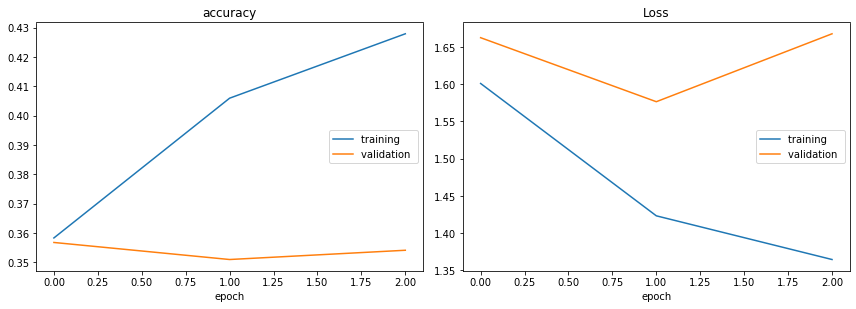

accuracy
	training         	 (min:    0.358, max:    0.428, cur:    0.428)
	validation       	 (min:    0.351, max:    0.357, cur:    0.354)
Loss
	training         	 (min:    1.365, max:    1.601, cur:    1.365)
	validation       	 (min:    1.577, max:    1.668, cur:    1.668)

Epoch 00003: saving model to model_mobilenetv2_weights_improved.h5
377/377 [==============================] - 937s 2s/step - loss: 1.3646 - accuracy: 0.4279 - val_loss: 1.6678 - val_accuracy: 0.3541


In [14]:
history = model.fit(x=train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    callbacks=callbacks)